In [2]:
import logging
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from models.generation import Model

from config import HUGGINGFACE_TOKEN, OPENAI_API_KEY, LLAMA_7B_PATH, GPT4ALL_PATH, LLAMA_13B_PATH

from helpers.data_helpers import save_to_parquet
from helpers.generation_helpers import generation_loop

logger = logging.getLogger(__name__)

2023-07-09 17:11:45,507 - INFO     | config     | Loading environment variables


In [2]:
# Global Flags
SLOW_COOLDOWN = 900 # for local models only
FAST_COOLDOWN = 10  # for local models only

N_TWEETS = 1000

RUN_ALL = False

# DATA Import

In [3]:
tweets = pd.read_parquet('data/eval_tweets_202342.parquet')
logger.info(f'{len(tweets)} tweets in generation set.')
logger.info(f'Generating from {N_TWEETS} tweets.')

2023-07-05 09:10:55,879 - INFO     | __main__   | 21711 tweets in generation set.
2023-07-05 09:10:55,880 - INFO     | __main__   | Generating from 1000 tweets.


In [4]:
# Select tweets
output_tweets = tweets.iloc[N_TWEETS:2000].copy()
output_tweets.drop(columns=['created_at', 'entities'], inplace=True)

output_tweets = output_tweets.iloc[400:].copy()

In [5]:
output_tweets

,id,full_text
1400,1642178534377488390,🚨🛒 big news for all shopify users this weekend...
1401,1642528275837722628,"oh, yes. he was a raging anti-semite. he even ..."
1402,1641589546398760962,#japan #monthly #retailtrades.a.(mom) japanese...
1403,1642517827033923585,"some facts like there are many teams ferari, ..."
1404,1642493639535239169,under armour women's charged running shoe
...,...,...
1995,1642547546777321472,yey black haired hoon this cb
1996,1642465085108162562,this good american assistant living homes gon...
1997,1642519982356439040,very true! but the thought of his mascara run...
1998,1642494923696996353,just fake lashes and make up with good lighti...


# Prompt Engineering

In [6]:
PROMPT_TEMPLATE = """Answer the question based on the context below.
Context: You are a marketing and customer relationship management assistant,
your task is to classify a given tweet as either a
potential lead or not. Provide your detailed analysis of the following tweet
as a potential lead in the context of marketing and customer relationship management. 
Answer with less than 100 words.
Tweet: "{tweet}"
Question: Is the above tweet a potential lead? Yes or No? Why?.
Answer: """

# Models

In [7]:
# OpenAI Model
openai = Model(model_name='openai',
               openai_api=OPENAI_API_KEY,
               openai_model='gpt-3.5-turbo',
               max_tokens=500)

if RUN_ALL:
    # injecting prompts
    openai.init_prompt(template=PROMPT_TEMPLATE,
                    input_vars=['tweet'])

    # generation
    output_tweets = generation_loop(model=openai,
                            model_col='gpt-3.5-turbo',
                            n=N_TWEETS,
                            tweets=output_tweets,
                            fast_cool=FAST_COOLDOWN,
                            slow_cool=120,
                            out_dir='outputs',
                            out_name='1000_2T')

2023-07-02 15:14:24,313 - INFO     | models.generation | 
Initializing OPENAI model  - Temp: 1e-10 - Context window: 2048 - Max tokens: 500


In [8]:
# Alpaca Model from Stanford, based on LLAMA
alpaca = Model(model_name='alpaca-770M',
               hf_api=HUGGINGFACE_TOKEN,
               hf_repo='declare-lab/flan-alpaca-large',
               max_tokens=500)

if RUN_ALL:
    # injecting prompt
    alpaca.init_prompt(template=PROMPT_TEMPLATE,
                    input_vars=['tweet'])

    # generation
    output_tweets = generation_loop(model=alpaca,
                                    model_col='alpaca',
                                    n=50,
                                    tweets=output_tweets,
                                    fast_cool=FAST_COOLDOWN,
                                    slow_cool=120,
                                    out_dir='outputs',
                                    out_name='1000_2T_alpaca_50')

2023-07-02 15:14:25,480 - INFO     | models.generation | 
Initializing ALPACA-770M model  - Temp: 1e-10 - Context window: 2048 - Max tokens: 500


In [7]:
# GPT4ALL, Fine-Tuned with OpenAI's model Q&As
gpt4all = Model(model_name='gpt4all',
                n_threads=6,
                local_model_path=GPT4ALL_PATH,
                max_tokens=500)

if RUN_ALL:
    # injecting prompt
    gpt4all.init_prompt(template=PROMPT_TEMPLATE,
                        input_vars=['tweet'])

    # generation
    output_tweets = generation_loop(model=gpt4all,
                                    model_col='gpt4all',
                                    n=600,
                                    tweets=output_tweets,
                                    fast_cool=FAST_COOLDOWN,
                                    slow_cool=SLOW_COOLDOWN,
                                    out_dir='outputs',
                                    out_name='1000T_2_gpt4all_600')

2023-07-05 09:11:17,802 - INFO     | models.generation | 
Initializing GPT4ALL model  - Temp: 1e-10 - Context window: 2048 - Max tokens: 500
llama_model_load: loading model from '.models/gpt4all-7B/gpt4all-converted.bin' - please wait ...
llama_model_load: n_vocab = 32001
llama_model_load: n_ctx   = 2048
llama_model_load: n_embd  = 4096
llama_model_load: n_mult  = 256
llama_model_load: n_head  = 32
llama_model_load: n_layer = 32
llama_model_load: n_rot   = 128
llama_model_load: f16     = 2
llama_model_load: n_ff    = 11008
llama_model_load: n_parts = 1
llama_model_load: type    = 1
llama_model_load: ggml map size = 4017.70 MB
llama_model_load: ggml ctx size =  81.25 KB
llama_model_load: mem required  = 5809.78 MB (+ 2052.00 MB per state)
llama_model_load: loading tensors from '.models/gpt4all-7B/gpt4all-converted.bin'
llama_model_load: model size =  4017.27 MB / num tensors = 291
llama_init_from_file: kv self size  = 2048.00 MB
2023-07-05 09:11:18,310 - INFO     | helpers.generation_he

  0%|          | 0/600 [00:00<?, ?it/s]

2023-07-05 09:30:30,987 - INFO     | helpers.generation_helpers | Step: 50 - Saving checkpoint and cooldown for 15.0m...
2023-07-05 09:30:31,008 - INFO     | helpers.data_helpers | 1000T_2_gpt4all_600.parquet saved.
2023-07-05 10:05:00,926 - INFO     | helpers.generation_helpers | Step: 100 - Saving checkpoint and cooldown for 15.0m...
2023-07-05 10:05:00,935 - INFO     | helpers.data_helpers | 1000T_2_gpt4all_600.parquet saved.
2023-07-05 10:44:42,001 - INFO     | helpers.generation_helpers | Step: 150 - Saving checkpoint and cooldown for 15.0m...
2023-07-05 10:44:42,009 - INFO     | helpers.data_helpers | 1000T_2_gpt4all_600.parquet saved.
2023-07-05 11:19:02,539 - INFO     | helpers.generation_helpers | Step: 200 - Saving checkpoint and cooldown for 15.0m...
2023-07-05 11:19:02,549 - INFO     | helpers.data_helpers | 1000T_2_gpt4all_600.parquet saved.
2023-07-05 11:53:26,191 - INFO     | helpers.generation_helpers | Step: 250 - Saving checkpoint and cooldown for 15.0m...
2023-07-05 

# Embeddings

In [8]:
# Load tweets and generations
df = pd.read_parquet('outputs/2000T_202375.parquet')

# Select model columns
model_cols = df.columns[2:]
model_cols

Index(['gpt-3.5-turbo', 'alpaca', 'gpt4all'], dtype='object')

In [9]:
from models.embeddings import SentenceEmbeddings

# Using distil-roberta for the sentence embeddings
distilrberta = SentenceEmbeddings(name='distil-roberta')

2023-07-05 21:33:47,674 - INFO     | models.embeddings | Initializing DISTIL-ROBERTA for Sentence Embeddings
2023-07-05 21:33:47,674 - INFO     | sentence_transformers.SentenceTransformer | Load pretrained SentenceTransformer: all-distilroberta-v1
2023-07-05 21:33:48,617 - INFO     | sentence_transformers.SentenceTransformer | Use pytorch device: cpu


In [10]:
# generating embeddings
embeddings_dict = {}
for col in model_cols:
    logger.info(f'Parsing model: {col}')
    embeddings_dict[col] = distilrberta.generate_embeddings(input_texts=df[col])

2023-07-05 21:33:50,640 - INFO     | __main__   | Parsing model: gpt-3.5-turbo
2023-07-05 21:33:50,641 - INFO     | models.embeddings | DISTIL-ROBERTA - Generating sentence embeddings...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2023-07-05 21:34:17,615 - INFO     | __main__   | Parsing model: alpaca
2023-07-05 21:34:17,616 - INFO     | models.embeddings | DISTIL-ROBERTA - Generating sentence embeddings...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2023-07-05 21:34:41,950 - INFO     | __main__   | Parsing model: gpt4all
2023-07-05 21:34:41,950 - INFO     | models.embeddings | DISTIL-ROBERTA - Generating sentence embeddings...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [11]:
# insert embeddings in dataframe
for col in model_cols:
    embeddings_col = col + '_embeddings'
    temp = pd.DataFrame({embeddings_col: embeddings_dict[col].tolist()})
    df[embeddings_col] = temp[embeddings_col].copy()

df.head()

,id,full_text,gpt-3.5-turbo,alpaca,gpt4all,gpt-3.5-turbo_embeddings,alpaca_embeddings,gpt4all_embeddings
0,1641514595339862016,thus continuing the roberts' (boebert's maide...,"No, this tweet is not a potential lead. The co...","Yes, this tweet is a potential lead because it...",\nThe given tweet is not a potential lead as i...,"[-0.03887094184756279, -0.1105034202337265, -0...","[0.011134546250104904, -0.0867694616317749, -0...","[-0.022826220840215683, -0.08779901266098022, ..."
1,1642044261649780736,my green &amp; black reputation eyeshadow look,No. The tweet does not provide any indication ...,"Yes, the tweet is a potential lead because it ...","\nNo, the above tweet is not a potential lead ...","[-0.024825602769851685, -0.10440673679113388, ...","[-0.022449074313044548, -0.08849964290857315, ...","[-0.02361299842596054, -0.1094249039888382, -0..."
2,1642124227590467584,i don't either but i put an eye liner for sha...,"No, the above tweet is not a potential lead. A...","Yes, the tweet is a potential lead because it ...",\nThe given tweet is not a potential lead as i...,"[-0.022488590329885483, -0.09907253086566925, ...","[-0.021942151710391045, -0.09090302884578705, ...","[0.007977220229804516, -0.06419841200113297, -..."
3,1642307728654888961,join the marketsource team! see our latest job...,"Yes, the above tweet is a potential lead. The ...","Yes, the tweet is a potential lead because it ...",\nThe given tweet is not a potential lead as i...,"[-0.0332973413169384, -0.09525896608829498, -0...","[-0.048098124563694, -0.09722025692462921, -0....","[-0.017496967688202858, -0.0763673409819603, -..."
4,1642521653497217025,check out mini oneida ceramic floral cherry te...,"No, the above tweet is not a potential lead. T...","Yes, the tweet is a potential lead because it ...","\nNo, the given tweet is not a potential lead....","[-0.017981532961130142, -0.08915165811777115, ...","[-0.007265061605721712, -0.09268850088119507, ...","[-0.010253571905195713, -0.08222711831331253, ..."


In [12]:
SAVE_FULL_DATA = False

In [13]:
if SAVE_FULL_DATA:
    # save full dataframe with embeddings and embeddings also separately
    save_to_parquet(data_dir='.', df=df, name='full_data')

    import pickle

    with open(f'embeddings/2000T_embeddings_202375.pkl', 'wb') as f:
        pickle.dump(embeddings_dict, f)

2023-07-05 21:35:02,040 - INFO     | helpers.data_helpers | full_data.parquet saved.


# Clustering

In [176]:
from models.clustering import ClusteringModel
from helpers.clustering_helpers import clustering_scores, dbscan_loop, kmeans_loop

import pickle
with open(f'embeddings/2000T_embeddings_202375.pkl', 'rb') as f:
        embeddings_dict = pickle.load(f)

df = pd.read_parquet('full_data_202375.parquet')

## KMeans

In [180]:
kmeans_overall_results = {}
for llm, embeddings in embeddings_dict.items():
    logger.info(f'{llm.upper()}')
    score, components, iters, n_cluster, tols = kmeans_loop(data=embeddings,
                                                            n_components_space=[None, 0.80, 0.90, 0.95, 0.99],
                                                            n_clusters_space = [2, 3, 4],
                                                            max_iter_space = [250],
                                                            tol_space = [1e-4, 1e-2])
                                                            
    kmeans_overall_results[llm] = {'embeddings': embeddings,
                                   'n_components': components,
                                   'max_iter': iters,
                                   'n_clusters': n_cluster,
                                   'tol': tols,
                                   'score': score}

2023-07-08 19:48:58,151 - INFO     | __main__   | GPT-3.5-TURBO
2023-07-08 19:49:39,134 - INFO     | __main__   | ALPACA
2023-07-08 19:50:16,397 - INFO     | __main__   | GPT4ALL


In [181]:
kmeans_best_results = pd.DataFrame(kmeans_overall_results)

,gpt-3.5-turbo,alpaca,gpt4all
embeddings,"[[-0.03887094, -0.11050342, -0.031814046, 0.02...","[[0.011134546, -0.08676946, -0.03891137, 0.060...","[[-0.02282622, -0.08779901, -0.021268817, -0.0..."
n_components,0.9,0.99,0.8
max_iter,250,250,250
n_clusters,2,3,2
tol,0.0001,0.0001,0.01
score,0.1199,0.114074,0.155638


In [182]:
kmeans_clusters = []
for llm, params in kmeans_overall_results.items():
    logger.info(llm.upper())
    kmeans = ClusteringModel(model_name='kmeans',
                             n_init='auto',
                             max_iter=params['max_iter'],
                             n_clusters=params['n_clusters'],
                             tol=params['tol'])
    kmeans.fit_predict(embeddings=params['embeddings'],
                       pca_flag=True,
                       n_components=params['n_components'])
    kmeans_clusters.append(kmeans.clusters)

2023-07-08 19:50:53,387 - INFO     | __main__   | GPT-3.5-TURBO
2023-07-08 19:50:54,533 - INFO     | __main__   | ALPACA
2023-07-08 19:50:55,672 - INFO     | __main__   | GPT4ALL


In [183]:
df['gpt-3.5-turbo_kmeans'] = kmeans_clusters[0]
df['alpaca_kmeans'] = kmeans_clusters[1]
df['gpt4all_kmeans'] = kmeans_clusters[2]

,id,full_text,gpt-3.5-turbo,alpaca,gpt4all,gpt-3.5-turbo_embeddings,alpaca_embeddings,gpt4all_embeddings,gpt-3.5-turbo_kmeans,alpaca_kmeans,gpt4all_kmeans
0,1641514595339862016,thus continuing the roberts' (boebert's maide...,"No, this tweet is not a potential lead. The co...","Yes, this tweet is a potential lead because it...",\nThe given tweet is not a potential lead as i...,"[-0.03887094184756279, -0.1105034202337265, -0...","[0.011134546250104904, -0.0867694616317749, -0...","[-0.022826220840215683, -0.08779901266098022, ...",1,0,1
1,1642044261649780736,my green &amp; black reputation eyeshadow look,No. The tweet does not provide any indication ...,"Yes, the tweet is a potential lead because it ...","\nNo, the above tweet is not a potential lead ...","[-0.024825602769851685, -0.10440673679113388, ...","[-0.022449074313044548, -0.08849964290857315, ...","[-0.02361299842596054, -0.1094249039888382, -0...",1,2,0
2,1642124227590467584,i don't either but i put an eye liner for sha...,"No, the above tweet is not a potential lead. A...","Yes, the tweet is a potential lead because it ...",\nThe given tweet is not a potential lead as i...,"[-0.022488590329885483, -0.09907253086566925, ...","[-0.021942151710391045, -0.09090302884578705, ...","[0.007977220229804516, -0.06419841200113297, -...",1,2,1
3,1642307728654888961,join the marketsource team! see our latest job...,"Yes, the above tweet is a potential lead. The ...","Yes, the tweet is a potential lead because it ...",\nThe given tweet is not a potential lead as i...,"[-0.0332973413169384, -0.09525896608829498, -0...","[-0.048098124563694, -0.09722025692462921, -0....","[-0.017496967688202858, -0.0763673409819603, -...",0,2,1
4,1642521653497217025,check out mini oneida ceramic floral cherry te...,"No, the above tweet is not a potential lead. T...","Yes, the tweet is a potential lead because it ...","\nNo, the given tweet is not a potential lead....","[-0.017981532961130142, -0.08915165811777115, ...","[-0.007265061605721712, -0.09268850088119507, ...","[-0.010253571905195713, -0.08222711831331253, ...",1,0,0


## DBSCAN

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming you have a dataset 'X' for PCA
pca = PCA()
pca.fit(embeddings_dict['alpaca'])

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed for a given level of explained variance
target_explained_variance = 0.99  # Set your desired level of explained variance
n_components = np.argmax(cumulative_variance_ratio >= target_explained_variance) + 1

# Print the number of components
print("Number of components needed:", n_components)

Number of components needed: 375


In [115]:
# Save df with clusters
df.to_parquet('full_data_202375.parquet', index=False)

# Analysis

In [3]:
df = pd.read_parquet('full_data_202375.parquet')
df.head()

,id,full_text,gpt-3.5-turbo,alpaca,gpt4all,gpt-3.5-turbo_embeddings,alpaca_embeddings,gpt4all_embeddings,gpt-3.5-turbo_kmeans,alpaca_kmeans,gpt4all_kmeans
0,1641514595339862016,thus continuing the roberts' (boebert's maide...,"No, this tweet is not a potential lead. The co...","Yes, this tweet is a potential lead because it...",\nThe given tweet is not a potential lead as i...,"[-0.03887094184756279, -0.1105034202337265, -0...","[0.011134546250104904, -0.0867694616317749, -0...","[-0.022826220840215683, -0.08779901266098022, ...",1,0,1
1,1642044261649780736,my green &amp; black reputation eyeshadow look,No. The tweet does not provide any indication ...,"Yes, the tweet is a potential lead because it ...","\nNo, the above tweet is not a potential lead ...","[-0.024825602769851685, -0.10440673679113388, ...","[-0.022449074313044548, -0.08849964290857315, ...","[-0.02361299842596054, -0.1094249039888382, -0...",1,2,0
2,1642124227590467584,i don't either but i put an eye liner for sha...,"No, the above tweet is not a potential lead. A...","Yes, the tweet is a potential lead because it ...",\nThe given tweet is not a potential lead as i...,"[-0.022488590329885483, -0.09907253086566925, ...","[-0.021942151710391045, -0.09090302884578705, ...","[0.007977220229804516, -0.06419841200113297, -...",1,2,1
3,1642307728654888961,join the marketsource team! see our latest job...,"Yes, the above tweet is a potential lead. The ...","Yes, the tweet is a potential lead because it ...",\nThe given tweet is not a potential lead as i...,"[-0.0332973413169384, -0.09525896608829498, -0...","[-0.048098124563694, -0.09722025692462921, -0....","[-0.017496967688202858, -0.0763673409819603, -...",0,2,1
4,1642521653497217025,check out mini oneida ceramic floral cherry te...,"No, the above tweet is not a potential lead. T...","Yes, the tweet is a potential lead because it ...","\nNo, the given tweet is not a potential lead....","[-0.017981532961130142, -0.08915165811777115, ...","[-0.007265061605721712, -0.09268850088119507, ...","[-0.010253571905195713, -0.08222711831331253, ...",1,0,0


In [6]:
kmeans_best_results

NameError: name 'kmeans_best_results' is not defined

# Data Viz

In [4]:
from helpers.data_viz import plot_clusters_2D, plot_wordcloud

/Users/lorenzo/.pyenv/versions/3.9.13/envs/thesis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lorenzo/.pyenv/versions/3.9.13/envs/thesis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lorenzo/Documents/repos/msc-thesis-llm-clustering/helpers/data_viz.py:65: UserWarning: Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from current font.
  plt.tight_layout()
/Users/lorenzo/Documents/repos/msc-thesis-llm-clustering/helpers/data_viz.py:65: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  plt.tight_layout()
/Users/lorenzo/Documents/repos/msc-thesis-llm-clustering/helpers/d

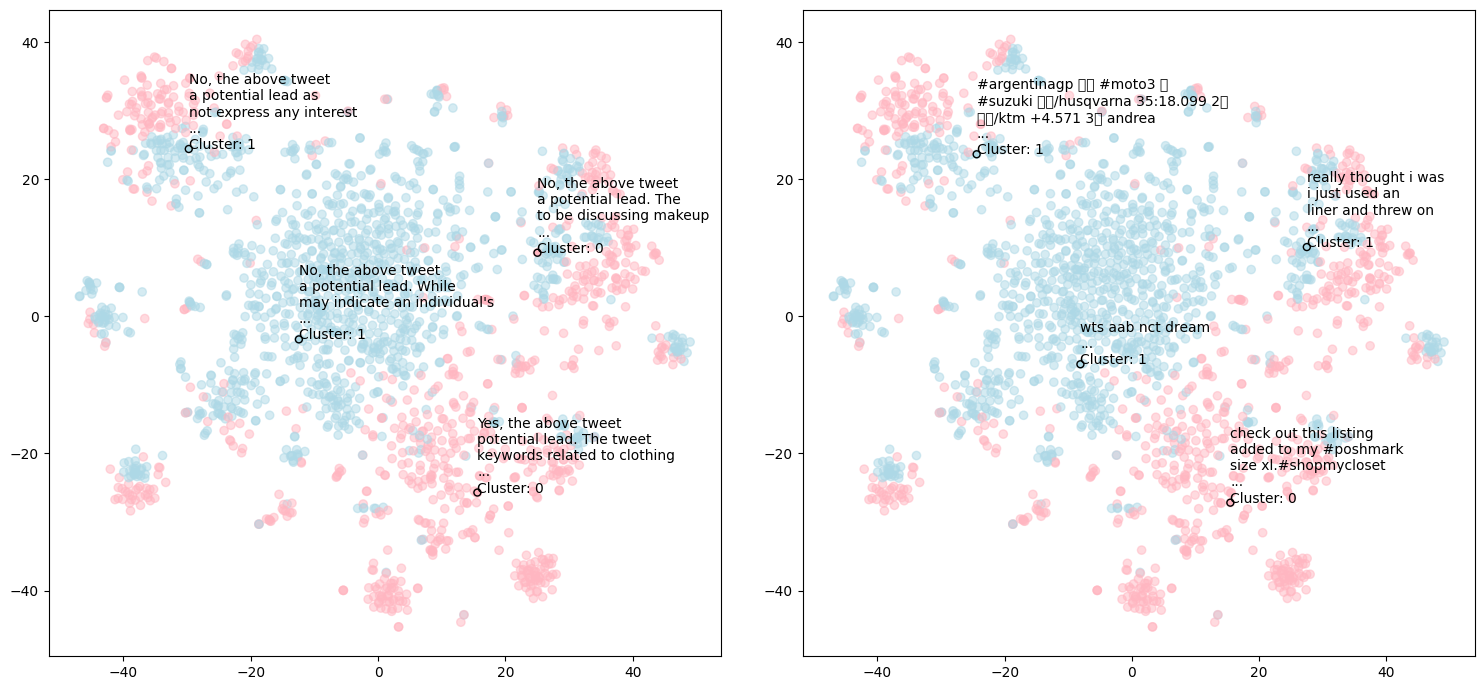

In [6]:
plot_clusters_2D(df=df,
                 model='gpt-3.5-turbo',
                 cluster_algo='kmeans',
                 save=False,
                 manual=False)